In [1]:
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from collections import defaultdict
import community
import operator
import argparse
import itertools
import gzip
import sys
import joypy
import pandas as pd
import matplotlib.ticker as mticker
import collections
import matplotlib.patches as mpatches
import powerlaw
%matplotlib inline

from network_ei import *
# from get_motifs import *

In [72]:
def softmax(A,k=1.0):
    """Calculates the softmax of a distribution, modulated by the precision term, k"""
    A = np.array(A) if not isinstance(A, np.ndarray) else A
    A = A*k
    maxA = A.max()
    A = A-maxA
    A = np.exp(A)
    A = A/np.sum(A)
    return A

In [2]:
print("Copy-Copy Network Approach:")
A = np.array([[1.0,0,0,0],[0,0,1.0,0],[0,1.0,0,0],[0,0,0,1.0]])
print(A)
print(" ")
print("\tEffective Information (DD): \t", np.round(get_EInet_DD(A), 6))
print("\tEffective Information (CI): \t", np.round(get_EInet_CI(A), 6))
print("\tEffective Information (EI): \t", np.round(get_EInet_EI(A), 6))

Copy-Copy Network Approach:
[[ 1.  0.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  0.  1.]]
 
	Effective Information (DD): 	 2.0
	Effective Information (CI): 	 2.0
	Effective Information (EI): 	 2.0


In [837]:
# A matrix is the matrix corresponding nodes to states. We've previously assumed this to be a diagonal of ones
# B matrix is our TPM
# C matrix is the in-degree
# D matrix is max ent, assuming this "intervention" aka not preferentially placing a walker down. this might change
# for example, if you are constrained or are sampling the network 

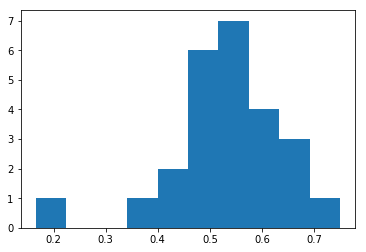

In [1077]:
Q = np.zeros(25)
Delt = np.zeros(25)
t = 0
N = 100
m = 2
for i in range(len(Q)):
    G = nx.barabasi_albert_graph(N, m)
    deg_vector = np.array(list(dict(G.degree()).values()))
    p0 = np.exp(-100)

    A = np.eye(N) 
    B = nx.to_numpy_array(G)
    C = deg_vector / sum(deg_vector)
    D = np.array([1/N]*N)

    No = A.shape[0]
    A = A + p0
    A = np.dot(A, np.diag(1. / np.sum(A,axis=0)))
    lnA = np.log(A)
    H = sum(A*lnA)

    Ns = B.shape[0]
    B = B + p0
    B = B / B.sum(axis=1)[:,None]

    C = C + p0
    C = C / sum(C)
    lnC = np.log(C)

    D = D + p0
    D = D / sum(D)
    D = np.array([D])
    D = D.T
    lnD = np.log(D)

    for current_node in range(A.shape[0]):
        s_tm1 = lnD[:,0]
        o_t = A[current_node,:]
        s_t = softmax(np.dot(lnA, o_t) + s_tm1)
        s_tau = np.dot(B, s_t)
        o_tau = np.dot(A, s_tau)

        predicted_uncertainty = np.dot(np.dot(np.ones(A.shape[0]), A*lnA), s_tau)
        predicted_divergence = np.dot(np.log(o_tau)-lnC, o_tau)
        Q_tau = predicted_uncertainty - predicted_divergence
        Q[i] = Q[i] + Q_tau/A.shape[0]
    
    Delt[i] = get_EInet_EI(G) + Q[i]

plt.hist(Delt);

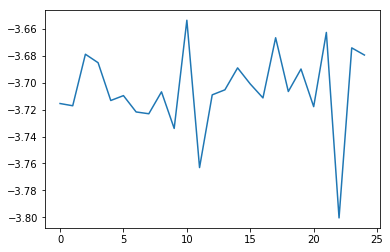

In [1078]:
plt.plot(Q)

In [1064]:
def do_log(thing, logbase=2):
    """Calculates the log based on which base you want"""
    if logbase==2:
        return np.log2(thing)
    if logbase==10:
        return np.log10(thing)
    if logbase=="e":
        return np.log(thing)    

In [1321]:
nsim = 50
logbase = 'e'
Q = np.zeros(nsim)
Eb = np.zeros(nsim)
Eg = np.zeros(nsim)
Delt = np.zeros(nsim)
t = 0
N = 125
m = 3
for i in range(len(Q)):
    G = nx.erdos_renyi_graph(N, 2*m/N)
#     G = nx.barabasi_albert_graph(N, m)
    deg_vector = np.array(list(dict(G.degree()).values()))
    p0 = np.exp(-18)

    A = np.eye(N) 
    B = nx.to_numpy_array(G)
    C = deg_vector / sum(deg_vector)
    D = np.array([1/N]*N)

    No = A.shape[0]
    A = A + p0
    A = np.dot(A, np.diag(1. / np.sum(A,axis=0)))
    lnA = do_log(A, logbase)
    H = sum(A*lnA)

    Ns = B.shape[0]
    B = B + p0
    B = B / B.sum(axis=1)[:,None]

    C = C + p0
    C = C / sum(C)
    lnC = do_log(C, logbase)

    D = D + p0
    D = D / sum(D)
    D = np.array([D])
    D = D.T
    lnD = do_log(D, logbase)

    for current_node in range(No):
        s_tm1 = lnD[:,0]
        o_t = A[current_node,:]
#         s_t = softmax(lnA[current_node,:] + s_tm1)
        s_t = softmax(np.dot(lnA, o_t) + s_tm1)
        s_tau = np.dot(B, s_t)
        o_tau = np.dot(A, s_tau)

#         predicted_uncertainty = sum(np.dot(np.ones(No), np.dot(H, s_tau)))
#         predicted_uncertainty = np.dot(np.dot(np.ones(No), H), s_tau)
        predicted_uncertainty = np.dot(np.dot(np.ones(No), A*lnA), s_tau)
        predicted_divergence = np.dot(do_log(o_tau, logbase)-lnC, o_tau)

        Q_tau = predicted_uncertainty + predicted_divergence
        Q[i] = Q[i] + np.abs(Q_tau/A.shape[0]) #+ 1/No
    
    Q[i] = Q[i] + 1
#     Q[i] = Q[i] + np.log2(G.number_of_edges()/G.number_of_nodes())
    Eg[i] = get_EInet_EI(G)
    Eb[i] = get_EInet_EI(B)
#     E[i] = get_EInet_EI(G)
    Delt[i] = E[i] - Q[i]
    if i % 10 == 0:
        print(i)

0
10
20
30
40


In [1327]:
for i in range(10):
    G = nx.barabasi_albert_graph(N,m)
    print(np.log(G.number_of_edges()/G.number_of_nodes()))

1.0743195961
1.0743195961
1.0743195961
1.0743195961
1.0743195961
1.0743195961
1.0743195961
1.0743195961
1.0743195961
1.0743195961


In [1235]:
# Q = Q + 1
# x = Q[Q<4.8]
# FE = x[x>4.4]
# EI = E[E>4.4]

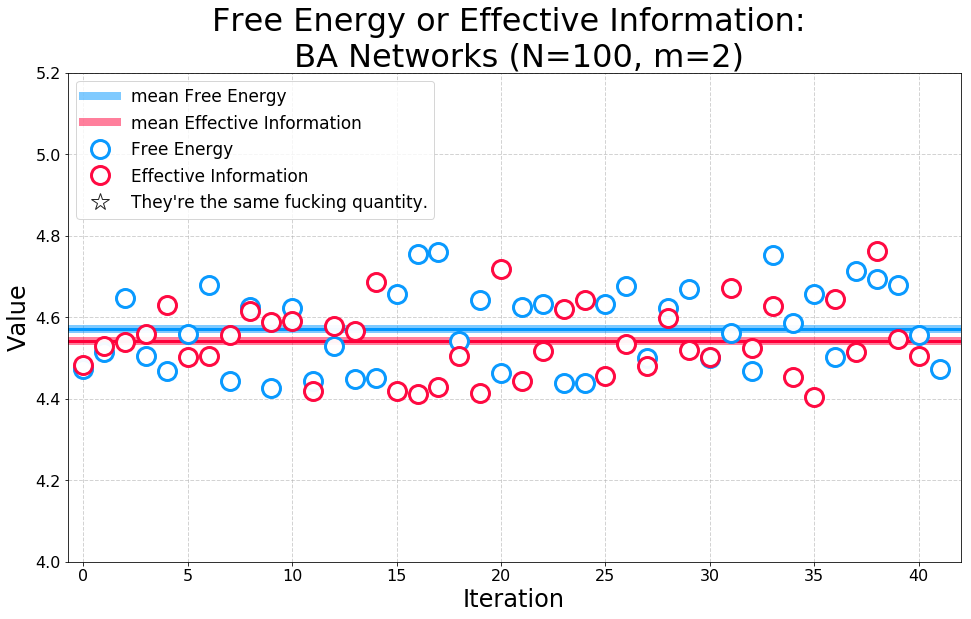

In [1172]:
plt.figure(figsize=(16,9))
plt.plot(range(-1,43), [np.mean(FE)]*44, alpha=0.5, color="#0096ff", linewidth=8.0, label="mean Free Energy")
plt.plot(range(-1,43), [np.mean(EI)]*44, alpha=0.5, color="#ff003a", linewidth=8.0, label="mean Effective Information")
plt.plot(range(-1,43), [np.mean(FE)]*44, color="#0096ff", linewidth=3.0)
plt.plot(range(-1,43), [np.mean(EI)]*44, color="#ff003a", linewidth=3.0)
plt.plot(FE, alpha=0.96, marker='o', markersize=18.0, color="#0096ff", markerfacecolor='w', 
         markeredgewidth=3, linewidth=0.0, label="Free Energy")
plt.plot(EI, alpha=0.96, marker='o', markersize=18.0, color="#ff003a", markerfacecolor='w', 
         markeredgewidth=3, linewidth=0.0, label="Effective Information")
plt.plot([6], [6], alpha=0.86, marker='*', markersize=18.0, color="k", markerfacecolor='w', 
         markeredgewidth=1, linewidth=0.0, label="They're the same fucking quantity.")
plt.xlabel("Iteration", size=24)
plt.ylabel("Value", size=24)
plt.xticks(size=16)
plt.yticks(size=16)
plt.ylim(4,5.2)
plt.xlim(-0.75,42)
plt.legend(fontsize=17, loc=2)
plt.grid(True, linestyle='--', linewidth=1.0, alpha=0.55)
plt.title("Free Energy or Effective Information: \n BA Networks (N=100, m=2)", size=32)#, fontweight='bold')
plt.show()
# plt.savefig("EffectiveInformation_FreeEnergy.png", dpi=425, bbox_inches='tight')
# plt.savefig("EffectiveInformation_FreeEnergy.pdf", dpi=425, bbox_inches='tight')

In [1316]:
import seaborn as sns
import scipy as sp

In [1345]:
# ei_b = Eb
# ei_g = Eg
# fe_b = Q
ei_b = Eb[Eb<4.6]
ei_b = ei_b[ei_b>4.34]
ei_g = Eg[Eg<4.6]
ei_g = ei_g[ei_g>4.34]
fe_b = Q[Q<4.6]
fe_b = fe_b[fe_b>4.34]

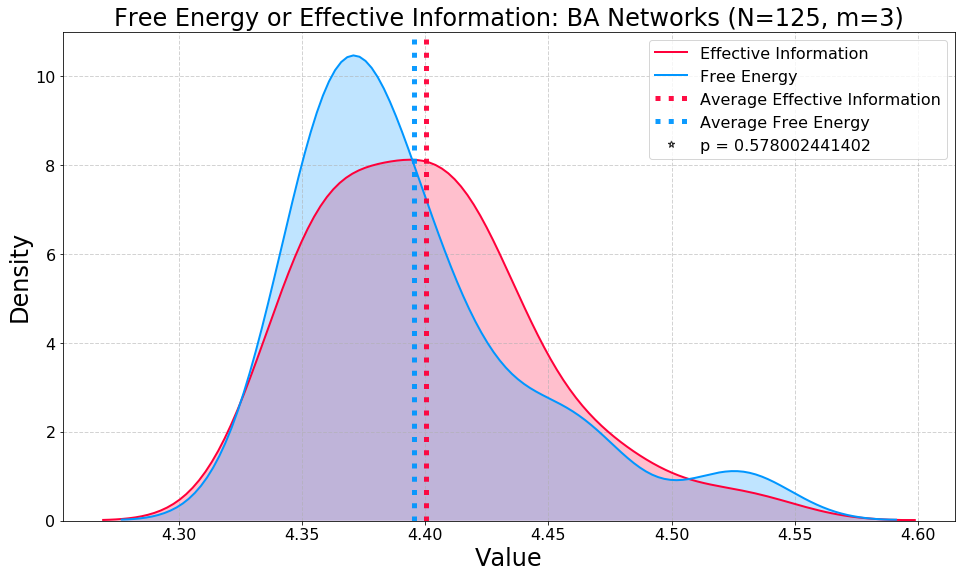

In [1370]:
_, p = sp.stats.ttest_ind(ei_g, fe_b, equal_var = False)
maxy = 11
plt.figure(figsize=(16,9))
sns.kdeplot(ei_b, color="#ff003a", shade=True, linewidth=2.0, label="Effective Information", legend=False)
# sns.kdeplot(ei_g, color="#ff003a", shade=True, linewidth=2.0, label="Effective Information G", legend=False)
sns.kdeplot(fe_b, color="#0096ff", shade=True, linewidth=2.0, label="Free Energy", legend=False)
plt.plot([np.mean(ei_b)]*2, [0,maxy], alpha=0.95, color="#ff003a", linestyle=':',
         linewidth=5.0, label="Average Effective Information")
# plt.plot([np.mean(ei_g)]*2, [0,maxy], alpha=0.95, color="#ff003a", linestyle=':',
#          linewidth=5.0, label="Average Effective Information G")
plt.plot([np.mean(fe_b)]*2, [0,maxy], alpha=0.95, color="#0096ff", linestyle=':',
         linewidth=5.0, label="Average Free Energy")
plt.plot([4.49995], [8.5], alpha=0.86, marker='*', markersize=6.5, color="k", markerfacecolor='w', 
         markeredgewidth=1, linewidth=0.0, label="p = %s"%p)

plt.legend(fontsize=16, loc=1)

plt.xlabel("Value", size=24)
plt.ylabel("Density", size=24)
plt.xticks(size=16)
plt.yticks(size=16)
plt.ylim(0,maxy)
# plt.xlim(4,5)
plt.grid(True, linestyle='--', linewidth=1.0, alpha=0.55)
plt.title("Free Energy or Effective Information: BA Networks (N=%s, m=%s)"%(N,m), size=24)
# plt.show()
# plt.savefig("EffectiveInformation_FreeEnergy_Density.png", dpi=425, bbox_inches='tight')
# plt.savefig("EffectiveInformation_FreeEnergy_Density.pdf", dpi=425, bbox_inches='tight')

In [1021]:
G = nx.barabasi_albert_graph(N, m)
deg_vector = np.array(list(dict(G.degree()).values())) + p0
    
P_otau_given_model = deg_vector / sum(deg_vector)
lnP_otau_given_model = np.log(P_otau_given_model)
Q_stau_given_otau_policly = A.T
Q_otau_given_policy = B
Q_stau_given_policly = 
Q_stau__otau_given_policly = 
P_otau_stau_given_policy = Q_stau_given_otau_policly * P_otau_given_model



In [ ]:
extrinsic_value = sum([sum(Q_otau_given_policy[i]*lnP_otau_given_model) for i in range(B.shape[0])])
epistemic_value = sum()

In [1003]:
A = np.eye(N) 
B = nx.to_numpy_array(G)
C = deg_vector / sum(deg_vector)
D = np.array([1/N]*N)

No = A.shape[0]
A = A + p0
A = np.dot(A, np.diag(1. / np.sum(A,axis=0)))
lnA = np.log2(A)
H = sum(A*lnA)

Ns = B.shape[0]
B = B + p0
B = B / B.sum(axis=1)[:,None]

C = C + p0
C = C / sum(C)
lnC = np.log2(C)

D = D + p0
D = D / sum(D)
D = np.array([D])
D = D.T
lnD = np.log2(D)


In [ ]:
def causal_emergence(G, T, nsim=10):
    
    Np = nsim
    for t in range(T):
        if t>0:
            
        else:
            u = np.zeros((Np, T))
            v = 
            s_t = softmax(np.dot(lnA, o_t) + s_tm1)
            

In [956]:
lnA[0,:]

array([   0.        , -144.26950409, -144.26950409, -144.26950409,
       -144.26950409, -144.26950409, -144.26950409, -144.26950409,
       -144.26950409, -144.26950409])

In [951]:
def run_MDP(T, A, B, C, D, G, V, lnA, lnC, o, O, s, S, U, P, x, u, a, W, w, b, alpha, lambd, beta, g, N_variter):
    
    for t in range(T):
        # expectations of allowable policies 
        if t > 0:
            j = ismember(V[t-1,:], a[t-1]+1)
            V = V[:,j]
            w = w[j]

            u[w,t] = u[w, t-1] / sum(u[w[t-1]])

            v      = lnA[int(o[t]), :] + np.log(np.dot(B[t-1][int(a[t-1])], x[:,t-1]))
            x[:,t] = softmax(v)

        else:
            # initialize expectations
            # u[:,t] = np.ones((Np,1)) / Np
            u[:,t] = np.ones((Np)) / Np
            v      = lnA[int(o[t]),:] + lnD[:,0]
            x[:,t] = softmax(v)

        # initialize Q matrix
        Q = np.zeros((V.shape[1],1))

        # Calculate the value of 
        for k in range(V.shape[1]):

            # path integral of expected free energy

            xt = x[:,t]

            for j in range(t, T):
                state_index = V[j, k] - 1
                xt = np.dot(B[j][state_index], xt)
                # xt = np.dot(B[j][state_index], x[:,t])
                ot = np.dot(A, xt)

                if True: # lol such a good joke lol it's always free energy

                    # Free Energy:
#                    utility = lnC[:,j] - np.log(ot)
                    utility = lnC[:,j]
                    expected_utility = np.dot(utility - np.log(ot), ot)
                    entropy = np.dot(H, xt)
                    Q[k] = Q[k] + entropy + expected_utility
#                    Q[k] = Q[k] + expected_utility # KL Control
#                    Q[k] = Q[k] + utility # Utility

        # Variational iterations (assuming precise inference about past action)
        for i in range(N_variter):

            # policy (u)
            u[w,t] = softmax(np.dot(W[t], Q)).T[0]

            # precision (W)
            b = lambd*b + (1 - lambd) * (beta - np.dot(u[w,t], Q)[0])
            W[t] = alpha / b

            gamma.append(W[t])

        # posterior expectations (control states)
        for j in range(Nu):
            for k in range(t,T):
                P[j,k] = np.sum(u[w[ismember(V[k,:],j+1)],t])    

        # select action from P        
        a[t] = np.nonzero(np.random.rand(1) < np.cumsum(P[:,t]))[0][0]

        # store this selected action
        U[int(a[t]), t] = 1


        # NOW sample the next state 
        if t < T-1:
            s.append(np.nonzero(np.random.rand(1) < np.cumsum(G[t][int(a[t])][:,s[t]]))[0][0])
            # now get the observed state
            o[t+1] = np.nonzero(np.random.rand(1) < np.cumsum(A[:,s[t+1]]))[0][0]

            W[t+1] = W[t]
            O[int(o[t+1]), t+1] = 1
            S[int(s[t+1]), t+1] = 1                
    
    return W, O, S

In [574]:
# policies
Np = 10
u = np.ones(Np)/Np # priors over different networks
Q = np.zeros(Np)

for i in range(N):
    v = lnA[i,:] + lnD[:,0]
    x = np.apply_along_axis(softmax, 0, v)
    xt = np.dot(B[i], x)
    ot = np.dot(A.T[i], xt)

    utility = lnC
#     expected_utility = sum([ot[i]*np.log(ot[i]/C[i]) for i in range(len(ot))])
    expected_utility = np.dot(utility-np.log(ot),ot)
    entropy = np.dot(H[i], xt)
    print(sum([ot[i]*np.log(ot[i]/C[i]) for i in range(N)]))
    
    print(entropy)
    print(expected_utility)
#     print("Entropy over states:",np.round(H,3))
#     print("Probability over states:",np.round(xt,3))
#     print("Likelihood of next node:",np.round(ot,3))
    Q[0] = Q[0] + entropy + expected_utility
    print(Q[0])
#     Q[0] = Q[0] + expected_utility

    
print(Q[0])
print(get_EInet_EI(G))

-5.28983583642e-08
-9.36762081796e-16
5.28983583642e-08
5.28983574274e-08
-5.28983583642e-08
-9.36762081796e-16
5.28983583642e-08
1.05796714855e-07
-4.51369455773e-08
-7.49409666535e-16
4.51369455773e-08
1.50933659683e-07
-4.4389308303e-08
-7.28592731468e-16
4.4389308303e-08
1.95322967257e-07
-5.28983583642e-08
-9.3676208111e-16
5.28983583642e-08
2.48221324685e-07
-4.84587560605e-08
-8.32677405965e-16
4.84587560605e-08
2.96680079912e-07
-5.28983583642e-08
-9.36762080423e-16
5.28983583642e-08
3.4957843734e-07
-5.28983583642e-08
-9.36762080423e-16
5.28983583642e-08
4.02476794767e-07
4.02476794767e-07
1.20017795128


In [555]:
ot

array([  6.37253116e-18,   6.37253116e-18,   6.37253116e-18,
         6.37253116e-18,   6.37253116e-18,   6.37253116e-18,
         6.37253116e-18,   3.09173033e-09])

In [479]:
# predicted_uncertaint = A*np.log(A) # EXPECTATION [H[P(ot|st)]]
# predicted_divergence = D[Q(ot|policy) || P(ot|m)]

In [480]:
# Q(ot|pi) 

In [481]:
# np.round(A,3)
# print(sum([-A[i]*np.log(A[i]) for i in range(A.shape[1])]))
print(sum([sum(-A[i]*np.log(A[i])) for i in range(A.shape[1])]))
print(-sum(H))
print(-np.dot(H[i], x[i])*len(H))

2.42391662312e-06
2.42391662312e-06
2.42391662512e-06


In [521]:
np.dot(H[i], x[i])*len(H)

-2.4239147156921042e-06

In [504]:
print(sum([ot[i]*np.log(ot[i]/C[i]) for i in range(N)]))
print(get_EInet_EI(G))

1.24245273671
1.18884190631


In [495]:
np.dot(A[i],np.dot(B[i], softmax(lnA[i,:]+lnD[:,0])))

array([  2.57644195e-09,   5.31044264e-18,   5.31044264e-18,
         5.31044264e-18,   5.31044264e-18,   5.31044264e-18,
         5.31044264e-18,   5.31044264e-18])

In [518]:
sum([get_effectInfo_net_i(G,i) for i in range(N)])/N
sum([get_effectInfo_net_i(G,i) for i in range(N)])/N

1.2478540366611584

In [529]:
np.dot(H[i],np.dot(B[i], x))

-3.4253081292702137e-14

In [300]:
# policies
Np = 10
u = np.ones(Np)/Np # priors over different networks
Q = np.zeros(Np)

for i in range(N):
    v = lnA[i,:] + lnD[:,0]
    x = np.apply_along_axis(softmax, 0, v)
    # x = softmax(v) # still gets you something like A
    #     xt = np.dot(B[i], x)
    xt = np.dot(B[i], x)
    ot = np.dot(A[i], xt)

    utility = lnC
#     expected_utility = sum([ot[i]*np.log(ot[i]/C[i]) for i in range(len(ot))])
    expected_utility = np.dot(utility-np.log(ot),ot)
    entropy = np.dot(H[i], xt)
#     print("Entropy over states:",np.round(H,3))
#     print("Probability over states:",np.round(xt,3))
#     print("Likelihood of next node:",np.round(ot,3))
    Q[0] = Q[0] + entropy + expected_utility
#     Q[0] = Q[0] + expected_utility

    
print(Q[0])
print(get_EInet_EI(G))

Entropy over states: [-0. -0. -0. -0. -0. -0. -0. -0.]
Probability over states: [ 0.    0.    0.25  0.25  0.25  0.25  0.    0.  ]
Likelihood of next node: [ 0.    0.    0.25  0.25  0.25  0.25  0.    0.  ]
Entropy over states: [-0. -0. -0. -0. -0. -0. -0. -0.]
Probability over states: [ 0.  0.  1.  0.  0.  0.  0.  0.]
Likelihood of next node: [ 0.  0.  1.  0.  0.  0.  0.  0.]
Entropy over states: [-0. -0. -0. -0. -0. -0. -0. -0.]
Probability over states: [ 0.143  0.143  0.     0.143  0.143  0.143  0.143  0.143]
Likelihood of next node: [ 0.143  0.143  0.     0.143  0.143  0.143  0.143  0.143]
Entropy over states: [-0. -0. -0. -0. -0. -0. -0. -0.]
Probability over states: [ 0.5  0.   0.5  0.   0.   0.   0.   0. ]
Likelihood of next node: [ 0.5  0.   0.5  0.   0.   0.   0.   0. ]
Entropy over states: [-0. -0. -0. -0. -0. -0. -0. -0.]
Probability over states: [ 0.5  0.   0.5  0.   0.   0.   0.   0. ]
Likelihood of next node: [ 0.5  0.   0.5  0.   0.   0.   0.   0. ]
Entropy over states: [-

In [302]:
np.dot(B, x[i])

array([  2.57644198e-09,   4.12230714e-09,   1.42857143e-01,
         3.09173037e-09,   3.09173037e-09,   2.49999997e-01,
         3.09173037e-09,   3.09173037e-09])

In [ ]:
lnC[i]